In [1]:
# 导入所需库

from __future__ import division
import os
from array import array
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy import stats
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.font_manager import FontProperties

import pyart

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature  
import cartopy.io.shapereader as shpreader
from cartopy.mpl.patch import geos_to_path

import seaborn as sns

sns.set_context("talk", font_scale=1.5)
font = FontProperties(fname='MicrosoftYaHei.ttf')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/usr/local/tools/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
def read_radar(filename, eleva, types, dupe = False, lonlat = None):
    """
        read SA/SB radar binary file
        
        Parameters:
        -----------------------
            filename: the name of radar binary file
                    .type. str
            eleva : elevation, depend on VCP mode
                    .type. float
            types: the type of product to read
                    .type. integer
                    1  meaning reflectivity, e.g. dBZ
                    2  meaning velocity
                    3  meaning spectral width
            dupe : whether read another elevation when the elevation carrying 
                   out multiple scanning.
                   .type. bool , optional
            lonlat : the lon/lat for radar. the first is latitude, second is longitude 
                   .type. list, optional 
                   
         Return:
         ----------------------
            nx  :  latitudes
            ny  :  longitudes
            dbz :  reflectivity, when types is 1  
             v  :  velocity, when types is 2
           spet :  spectral width, when types is 3   

        >>> filename = "sa.bin"
        >>> eleva = 0.5
        >>> types = 1
         # read reflectivity and no coordinate of radar
        >>> nx, ny, dbz = read_radar(filename, eleva, types)
        >>> lonlat = [32.4, 118.1]
         # read reflectivity with coordinate of radar 
        >>> lat, lon, dbz = read_radar(filename, eleva, types, lonlat = lonlat)
         # read velocity for another scanning from multiple scanning the elevation  
        >>> dupe = True
        >>> types = 2
        >>> lat, lon, v = read_radar(filename, eleva, types, lonlat = lonlat, dupe = dupe)
         # read spectral width
        >>> types = 3
        >>> lat, lon, spectral = read_radar(filename, eleva, types, lonlat = lonlat)
    """
    num = 2432
    
    with open(filename, mode = "rb") as file:
        data = np.asarray(array("B", file.read()))
        
    data = data.reshape([data.size//num, num])
    
    vcp = data[0, 72]

    if vcp == 11:        
        phi = [0.50, 0.50, 1.45, 1.45, 2.40, 3.35, 4.30, 5.25,
                6.2, 7.5, 8.7, 10, 12, 14, 16.7, 19.5]
    elif vcp == 21:
        phi = [0.50, 0.50, 1.45, 1.45, 2.40, 3.35, 4.30, 6.00, 
                9.00, 14.6, 19.5]
    elif vcp == 31:
        phi = [0.50, 0.50, 1.50, 1.50, 2.50, 2.50, 3.50, 4.50]
    elif vcp == 32:
        phi = [0.50, 0.50, 2.50, 3.50, 4.50]
    else:
        raise ValueError("无法识别此体扫模式：%d" % vcp)
        
    if eleva not in phi:
        print("仰角的值应在以下列表中：")
        print(phi)
        raise ValueError("体扫模式为 %d, 仰角 %4.2f 不在此模式中!" % (vcp, eleva))        
    else:    
        #计算仰角数
        elev_num = data[:,44] + data[:,45]*256    
        elevs = np.unique(elev_num) # 总仰角层数 
#        print('Elevation NUmber: ', elevs)
        if dupe:
            if (eleva in [0.50, 1.45] and vcp in [11, 21]) or \
               (eleva in [0.50, 1.50] and vcp == 31) or \
               (eleva in [0.50] and vcp == 32):     
                phiidx = phi.index(eleva) + 1
            else:
                raise ValueError("仰角%4.2f没有进行多次扫描！" % eleva)
        else:
            phiidx = phi.index(eleva)
        # 获取某一仰角的起始径向编号       
        eleidx = np.squeeze(list(np.nonzero(elev_num == phiidx + 1)))         
        eleidse = np.arange(eleidx[0], eleidx[-1] + 1)    
#        print('Ray start index : ', eleidx)
        
        if types == 1:
            start = 128    
            # 读取反射率库数    
            dnums = data[eleidse, 54] + data[eleidse, 55]*256 
            distance = np.unique(data[eleidse, 50] + data[eleidse, 51]*256)/1000

            nx, ny, dbz = get_data(data, eleidse, dnums, distance[0], eleva, start, lonlat)
            
            return (nx, ny, (dbz-2)/2 - 32)
            
        elif types == 2:
            start = 128
            # 读取指定仰角所有径向的库数
            dnums = data[eleidse, 56] + data[eleidse, 57]*256
            distance = np.unique(data[eleidse, 52] + data[eleidse, 53]*256)/1000
            # 读取速度分辨率
            ress = data[eleidse[0], 70] + data[eleidse[0], 71] * 256
            res = np.unique(ress)

            if res.size != 1:
                raise ValueError("同一仰角径向数据中出现多个速度分辨率!")
            else:                
                if res[0] == 2:
                    nx, ny, v = get_data(data, eleidse, dnums, distance[0], eleva, start, lonlat)  
                    
                    return (nx, ny, (v-2)/2 - 63.5)                
                elif res[0] == 4:
                    nx, ny, v = get_data(data, eleidse, dnums, eleva, start, lonlat)  
    
                    return (nx, ny, (v-2) - 127)               
                else:
                    raise ValueError("速度分辨率读取错误！读取值为：%d，应为 2 或 4." % res[0])
        elif types == 3:
            start = 1048             
            # 读取指定仰角所有径向的库数
            dnums = data[eleidse, 56] + data[eleidse, 57]*256
            distance = np.unique(data[eleidse, 52] + data[eleidse, 53]*256)/1000
            
            nx, ny, spet = get_data(data, eleidse, dnums, distance[0], eleva, start, lonlat)
            
        else:
            raise ValueError("不支持读取此类型数据！")                 
        
def get_data(data, eleidse, dnums, distance, eleva, start, lonlat): 

    dnum = np.unique(dnums)
    
    if dnum.size != 1:
        raise ValueError("库数出现不同值，可能是索引出错！") 
    else:    
        if dnum[0] == 0: 
            raise ValueError("仰角%4.2f没有反射率数据！" % eleva)
        else:    
            # 读取仰角，方位角和库长    
#            print('Kuchang : ', dnum[0])
            amu = (data[eleidse, 36] + data[eleidse, 37]*256)/8*180/4096
            amusize = amu.size
            amus = amu.repeat(dnum[0]).reshape([amusize, dnum[0]])
            elevas = np.tile(eleva, [amusize, dnum[0]])        
            r = (np.arange(dnum[0]))*distance 
          
            nx, ny, nz = sph2cart(elevas, amus, r, lonlat)
            prod = data[eleidse, start:dnum[0] + start]
            
            prod[prod == 1] = 0
            prod = np.float64(prod)
            
            return (nx, ny, prod)                  
            
def sph2cart(elevation, azimuth, r, lonlat):

    ele, a = np.deg2rad([elevation,azimuth])
    x = r * np.cos(ele) * np.cos(a)
    y = r * np.cos(ele) * np.sin(a)
    z = r * np.sin(ele)
    
    if lonlat is None:
        return x,y,z        
    else:
        return km2deg(x) + lonlat[0], km2deg(y) + lonlat[1], z
        
def km2deg(km):
    """
        convert kilometers to degree
        Input arguments:
            km: array of kilometers
                .type. numpy.array
        Return:
            deg: array of degree 
                .type. numpy.array
    """
    from numpy import pi, array
    
    radius = 6370.997
    rad = array(km)/radius
    
    deg = (rad*360)/(2*pi)    
    
    return deg


## 计算指定网格内闪电次数及工具函数
# get_ticks   :  主要用于将 colorbar 的 ticklabels 设置为时间格式
# get_density :  计算给定网格点内闪电出现的次数
# hex_to_rgb  :  转换 hex 颜色为 rgb 或 rgba

def get_ticks(mappable, step):
    """get colorbar ticks of mappable
    
    Agrs:
    
        mappable:
        
        step:
    
    Return:
        ticks
    """
    
    ticks = [mappable.colorbar.vmin]
    t = step
    while ticks[-1] < mappable.colorbar.vmax:
        ticks.append(mappable.colorbar.vmin + t*3600*1e9)
        t += step
    ticks[-1] = mappable.colorbar.vmax
    
    return ticks  

def get_density(longitudes, latitudes, binx, biny):
    """ 计算给定网格中经纬度数据出现的次数
    """
    
    return stats.binned_statistic_2d(longitudes, latitudes, None, 'count', bins=[binx, biny])

def hex_to_rgb(hexs, rgba=False):
    """convert hex to rgb or rgba
    
    parameters:
        hexs  : hexs color array.  list or np.array
        rgba  : control whether convert rgba.  logical
    """
    rgbs = []
    for h in hexs:
        rgb = [int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
        rgbs.append(rgb)

    if rgba:
        return colors.to_rgba_array(np.array(rgbs)/255)
    else:
        return np.array(rgbs)/255
    
def getflash(data, lon=None, lat=None, resample=None, factor=None, time_range=None, tdelta=None):
    """处理闪电数据
    
    参数：
        data     : 闪电数据. pandas.DataFrame  
        lon      : X方向的范围，用来筛选闪电.   list with two integer
        lat      : Y方向的范围，用来筛选闪电.   list with two integer
        resample : 对数据进行重采样,一般是对时间进行重采样. 比如每5分钟进行计数，统计5分钟内闪电次数. str
                    默认值为: "5min"，表示统计5分钟内闪电次数
        factor   : 和 resample 的值要一致，如果resample 是5min重采样一次，那么 factor = 5.  integer
      time_range :
        tdelta   : 时间偏差
        
     返回：
         data : 处理后的闪电数据
    """
    
    if tdelta is not None:
        data.index = data.index + tdelta
    data["cg"] = 1   
    
    data["pos"] = 0
    data.loc[data["intensity"] > 0, "pos"] = 1
    data["neg"] = 0
    data.loc[data["intensity"] < 0, "neg"] = 1  


    if lon:
        xindx = data.lon.between(lon[0], lon[1])
        data = data[xindx]
    if lat:   
        yindx = data.lat.between(lat[0], lat[1])
        data = data[yindx]        

    if resample:
        data = data.resample(resample).sum()
    else:
        resample = "5min"
        factor = 5
        data = data.resample(resample).sum()
        
    if factor:
        return data[["cg", "pos", "neg"]]/factor   
    else:
        return data[["cg", "pos", "neg"]]  

绘制雷达基本反射率(未进行质量控制)

/usr/local/tools/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


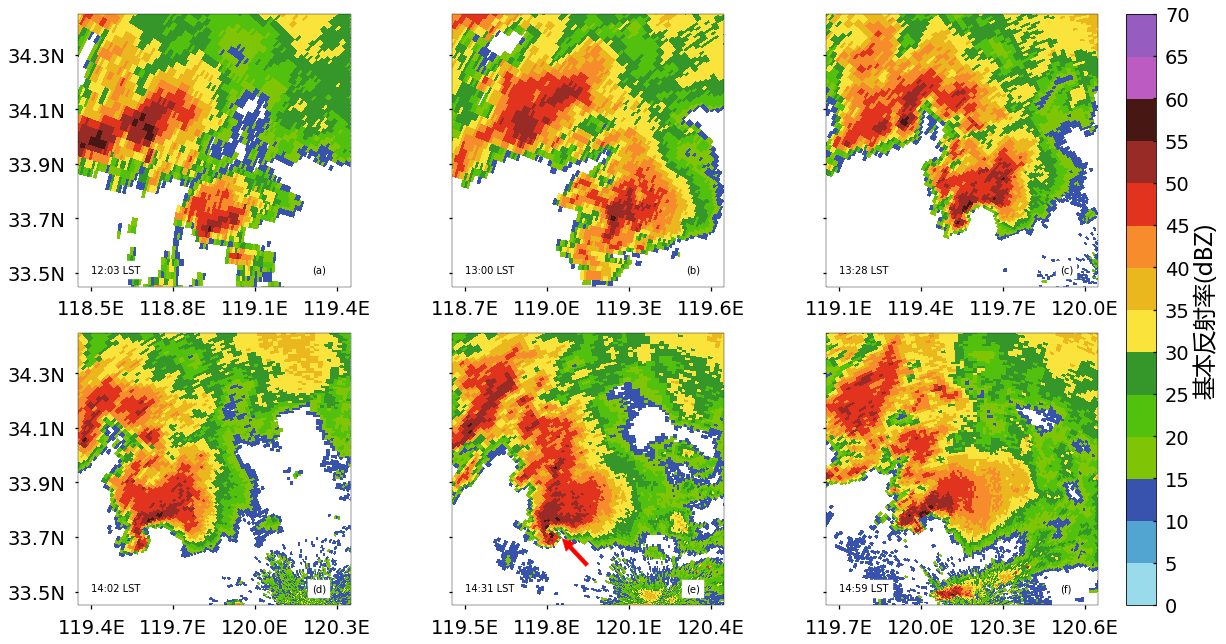

In [7]:
fp = "/Users/yanglee/Documents/毕业论文/个例数据/radar/"

fns = ["Z_RADR_I_Z9515_20160623040300_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623050000_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623055700_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623060200_O_DOR_SA_CAP.bin", 
       "Z_RADR_I_Z9515_20160623063100_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623065900_O_DOR_SA_CAP.bin",
      ]

proj = ccrs.PlateCarree()
eleva = 0.5
types = 1

ft = 14

#====================================================================================================
## colormap 
if 0:
    colev = ["#FFFFFF", "#00ECEC", 
             "#00A0F6", "#0000F6", 
             "#00FF00", "#00C800", 
             "#009000", "#FFFF00", 
             "#E7C000", "#FF0000", 
             "#D60000", "#C00000",
             "#FF00FF", "#9955C9"]

if 1:
    colev = ["#99DBEA", "#52A5D1", "#3753AD", "#80C505", "#52C10D", 
             "#35972A", "#FAE33B", "#EAB81E", "#F78C2C", "#E2331F",
             "#992B27", "#471713", "#BC5CC2", "#975CC0"]

cmaps = colors.ListedColormap(colev)   

levels = np.arange(0, 71, 5)
norm = colors.BoundaryNorm(levels, cmaps.N)

#====================================================================================================

#====================================================================================================
## axes 参数
xmins = [118.5, 118.7, 119.1, 119.4, 119.5, 119.7]
xmaxs = [119.4, 119.6, 120.0, 120.3, 120.4, 120.6]
ymins = [33.5, 33.5, 33.5, 33.5, 33.5, 33.5]
ymaxs = [34.4, 34.4, 34.4, 34.4, 34.4, 34.4]

## 图形注释
xlocs = np.repeat(0.9, 6)
ylocs = np.repeat(0.05, 6)
texts = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

titles = ["12:03 LST",
          "13:00 LST",
          "13:28 LST",
          "14:02 LST",
          "14:31 LST",
          "14:59 LST",
         ]

## axes labels 显示格式
lon_formatter = LongitudeFormatter(number_format=".1f",
                               degree_symbol="",
                               dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format=".1f",
                                   degree_symbol="")
#====================================================================================================

#====================================================================================================
## 开始绘图
fig, axes = plt.subplots(figsize=[20, 9], nrows=2, ncols=3, 
                         subplot_kw=dict(projection=proj),
#                         sharex=True, sharey=True, 
                        )

for fn, ax, num, xloc, yloc, text, title, xmin, xmax, ymin, ymax in zip(fns, 
                                                                        axes.ravel(), 
                                                                        np.arange(0, 6), 
                                                                        xlocs, 
                                                                        ylocs, 
                                                                        texts,
                                                                        titles,
                                                                         xmins, 
                                                                         xmaxs, 
                                                                         ymins,
                                                                         ymaxs
                                                                         ):

    nx, ny, dbz = read_radar(os.path.join(fp, fn), eleva, types, lonlat = [33.431, 120.201])  
    
    dbz[dbz <= 10] = np.nan

    con = ax.pcolormesh(ny, nx, dbz, vmin=0, vmax=70, cmap=cmaps, norm=norm)      

    ## axes 参数设置
    ax.set_xlim([xmin - 0.05, xmax + 0.05])
    ax.set_ylim([ymin - 0.05, ymax + 0.05])
    
    ax.set_xticks(np.arange(xmin , xmax + 0.05, 0.3))
    ax.set_yticks(np.arange(ymin, ymax + 0.05, 0.2))
    
    ax.set_xticklabels(np.arange(xmin, xmax + 0.01, 0.3),) #fontdict=dict(fontsize=ft))
    ax.set_yticklabels(np.arange(ymin, ymax + 0.01, 0.2),) #fontdict=dict(fontsize=ft))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)  
    
    ax.text(0.86, 0.05, text, 
#            fontdict=dict(fontsize=34), 
            backgroundcolor="white",
            transform=ax.transAxes)
    
    ax.text(0.05, 0.05, title, 
#            fontdict=dict(fontsize=ft), 
            backgroundcolor="white",
            transform=ax.transAxes)    
    
#    ax.set_title(title, fontdict=dict(fontsize=ft))
    
    ax.set_aspect('equal')
    ax.set_adjustable('box-forced') 
    
#====================================================================================================    
## 设置 panel 图形信息
    if num in [0, 1, 2]:
#        ax.set_xticklabels([])
        if num in [1, 2]:
            ax.set_yticklabels([])
    elif num in [4, 5]:
        ax.set_yticklabels([])       
    
    if num == 4:
        ax.annotate("",
            xy=(119.85, 33.70), 
            xytext=(0.48, 0.12),
            textcoords="figure fraction",
            arrowprops=dict(facecolor="red", shrink=0.05, edgecolor="red"),
            horizontalalignment="right",
            verticalalignment="bottom",
#            fontsize=30,
            color="red")
#====================================================================================================

fig.tight_layout()  

## 共享 colorbar
cb = fig.colorbar(con, ax = axes, pad=0.02) 
cb.ax.tick_params(direction = "in")
cb.set_ticks(levels)
cb.ax.set_yticklabels(levels,) #fontdict=dict(fontsize=ft))
cb.ax.set_ylabel("基本反射率(dBZ)", fontdict=dict(fontsize=ft), fontproperties=font)
con.cmap.set_under('#FFFFFF') 

if 0:
    plt.savefig("/Users/yanglee/Documents/毕业论文/figure/20160623_观测雷达反射率.png", 
#                dpi=600, 
                bbox_inches="tight")

plt.show()

以下是论文中所使用到的图，除绘制了雷达基本反射率之外，还叠加了地闪数据

首先处理地闪数据

In [10]:
## 处理闪电数据

data = pd.read_csv("/Users/yanglee/Documents/毕业论文/个例数据/20160623.txt", 
                   infer_datetime_format=True, 
#                   usecols=np.arange(1, 9)
                   sep=r"\s+",   # 使用原生字符避免出现警告信息
                   encoding="utf-8",
                   skiprows=0,
                   names=["num", "date", "time", "lat", "lon", "intensity", "slope", "error", "style", "pro", "city", "county"])

try:
    data[["lat", "lon", "intensity", "slope", "error"]] = data[["lat", "lon", "intensity", "slope", "error"]].applymap(lambda x: x.split("=")[1])
    data[["lat", "lon", "intensity", "slope", "error"]] = data[["lat", "lon", "intensity", "slope", "error"]].astype(np.float)
    data[["style", "pro", "city", "county"]] = data[["style", "pro", "city", "county"]].applymap(lambda x: x.split(":")[1])
except IndexError as e:
    print(e)
    raise IndexError("Count error when split string! Please check out!")

data.index = pd.to_datetime(data.date.map(str) + " " + data.time, format="%Y%m%d %H:%M:%S.%f")

#data.index = pd.to_datetime(data.date.map(str) + " " + data.time, format="%Y%m%d %H:%M:%S.%f")
data = data[["lat", "lon", "intensity", "slope", "error", "style"]]

/usr/local/tools/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


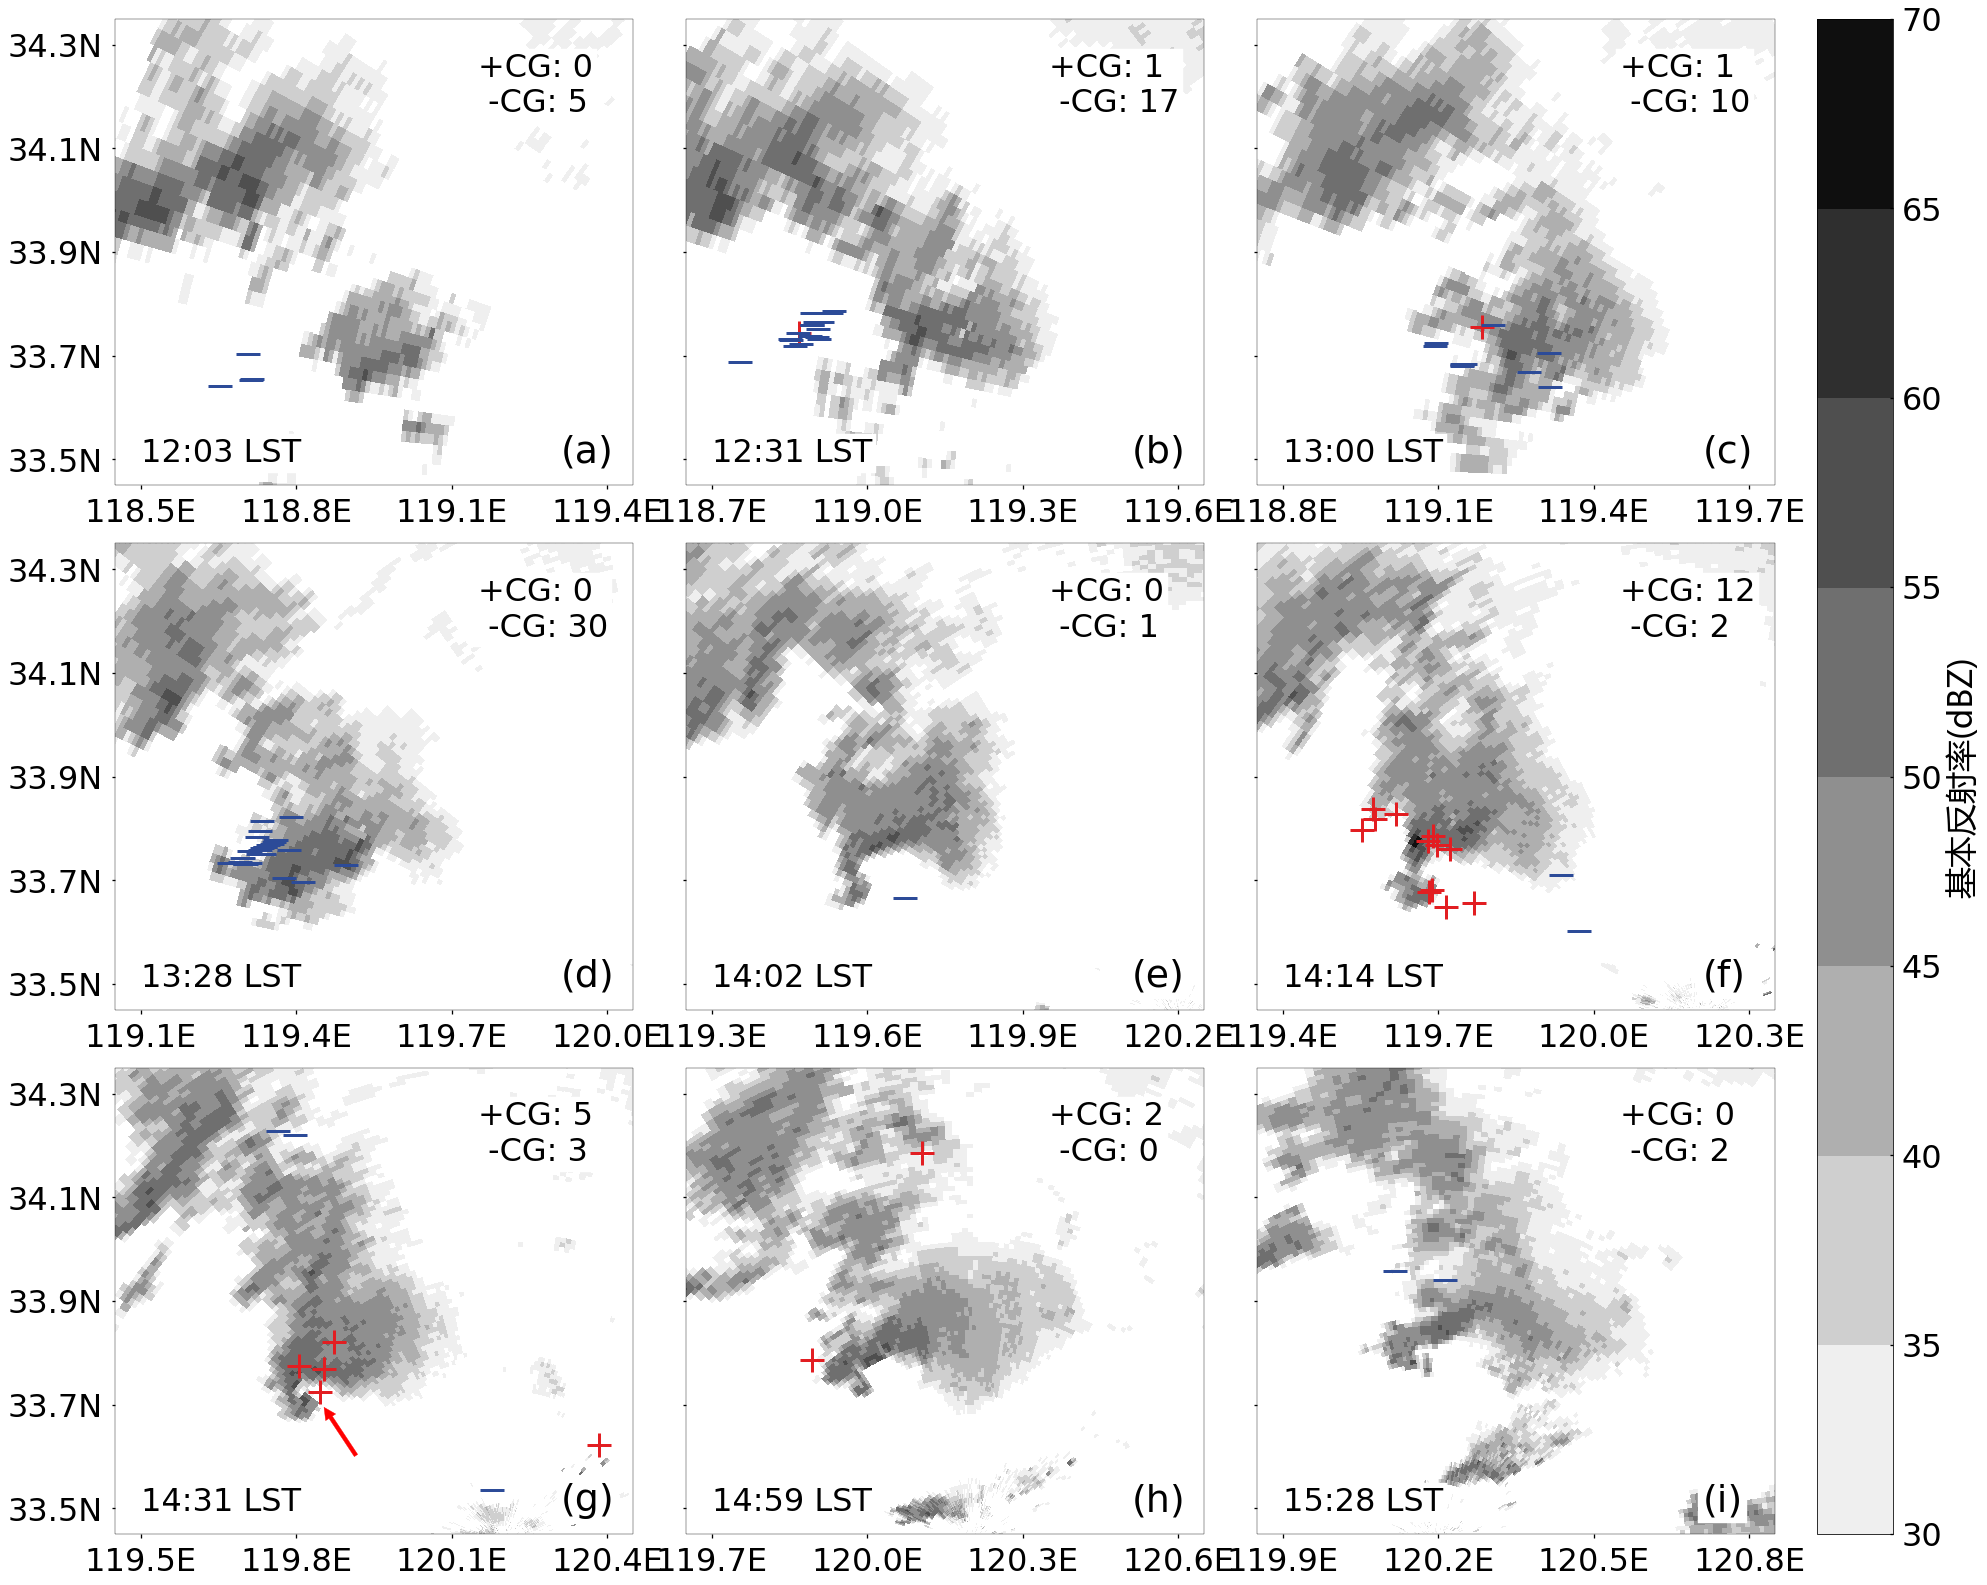

In [13]:
fp = "/Users/yanglee/Documents/毕业论文/个例数据/radar/"

fns = ["Z_RADR_I_Z9515_20160623040300_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623043100_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623050000_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623052800_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623060200_O_DOR_SA_CAP.bin", 
       "Z_RADR_I_Z9515_20160623061400_O_DOR_SA_CAP.bin", 
       "Z_RADR_I_Z9515_20160623063100_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623065900_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623072800_O_DOR_SA_CAP.bin",
      ]

ft = 32
font.set_size(ft)
blue = np.array([44, 75, 152])/255
red = np.array([226, 30, 34])/255

proj = ccrs.PlateCarree()
eleva = 0.5
types = 1

#====================================================================================================
## colormap 
if 0:
    colev = ["#FFFFFF", "#00ECEC", 
             "#00A0F6", "#0000F6", 
             "#00FF00", "#00C800", 
             "#009000", "#FFFF00", 
             "#E7C000", "#FF0000", 
             "#D60000", "#C00000",
             "#FF00FF", "#9955C9"]

if 0:
    colev = ["#99DBEA", "#52A5D1", "#3753AD", "#80C505", "#52C10D", 
             "#35972A", "#FAE33B", "#EAB81E", "#F78C2C", "#E2331F",
             "#992B27", "#471713", "#BC5CC2", "#975CC0"]
    
if 1:
    colev = ["#EFEFEF", "#CFCFCF", "#AFAFAF", "#8F8F8F", 
             "#6F6F6F", "#4F4F4F", "#2F2F2F", "#0F0F0F"]

cmaps = colors.ListedColormap(colev)   

levels = np.arange(30, 71, 5)
norm = colors.BoundaryNorm(levels, cmaps.N)

#====================================================================================================

#====================================================================================================
## axes 参数
xmins = [118.5, 118.7, 118.8, 119.1, 119.3, 119.4, 119.5, 119.7, 119.9]
xmaxs = [119.4, 119.6, 119.7, 120.0, 120.2, 120.3, 120.4, 120.6, 120.8]
ymins = [33.5, 33.5, 33.5, 33.5, 33.5, 33.5, 33.5, 33.5, 33.5]
ymaxs = [34.3, 34.3, 34.3, 34.3, 34.3, 34.3, 34.3, 34.3, 34.3]

## 图形注释
xlocs = np.repeat(0.9, 9)
ylocs = np.repeat(0.05, 9)
texts = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]

titles = ["12:03 LST",
          "12:31 LST",
          "13:00 LST",
          "13:28 LST",
          "14:02 LST",
          "14:14 LST",
          "14:31 LST",
          "14:59 LST",
          "15:28 LST",
         ]

dates = [["2016-06-23 12:02:00", "2016-06-23 12:05:00"],
         ["2016-06-23 12:30:00", "2016-06-23 12:33:00"],
         ["2016-06-23 12:59:00", "2016-06-23 13:02:00"],
         ["2016-06-23 13:27:00", "2016-06-23 13:30:00"],
         ["2016-06-23 14:01:00", "2016-06-23 14:04:00"],
         ["2016-06-23 14:13:00", "2016-06-23 14:16:00"],
         ["2016-06-23 14:30:00", "2016-06-23 14:33:00"],
         ["2016-06-23 14:58:00", "2016-06-23 15:01:00"],
         ["2016-06-23 15:27:00", "2016-06-23 15:30:00"],
        ]

## axes labels 显示格式
lon_formatter = LongitudeFormatter(number_format=".1f",
                               degree_symbol="",
                               dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format=".1f",
                                   degree_symbol="")
#====================================================================================================

#====================================================================================================
## 开始绘图
fig, axes = plt.subplots(figsize=[30, 22], nrows=3, ncols=3, 
                         subplot_kw=dict(projection=proj),
#                         sharex=True, sharey=True, 
                        )

for fn, ax, num, xloc, yloc, text, title, xmin, xmax, ymin, ymax, date in zip(fns, 
                                                                        axes.ravel(), 
                                                                        np.arange(0, 9), 
                                                                        xlocs, 
                                                                        ylocs, 
                                                                        texts,
                                                                        titles,
                                                                         xmins, 
                                                                         xmaxs, 
                                                                         ymins,
                                                                         ymaxs,
                                                                         dates
                                                                         ):

    nx, ny, dbz = read_radar(os.path.join(fp, fn), eleva, types, lonlat = [33.431, 120.201])  
    
    dbz[dbz <= 10] = np.nan

    con = ax.pcolormesh(ny, nx, dbz, vmin=levels[0], vmax=levels[-1], cmap=cmaps, norm=norm)      

    ## axes 参数设置
    ax.set_xlim([xmin - 0.05, xmax + 0.05])
    ax.set_ylim([ymin - 0.05, ymax + 0.05])
    
    ax.set_xticks(np.arange(xmin , xmax + 0.05, 0.3))
    ax.set_yticks(np.arange(ymin, ymax + 0.05, 0.2))
    
    ax.set_xticklabels(np.arange(xmin, xmax + 0.01, 0.3), fontdict=dict(fontsize=ft))
    ax.set_yticklabels(np.arange(ymin, ymax + 0.01, 0.2), fontdict=dict(fontsize=ft))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)  
    
    ax.text(0.86, 0.05, text, 
            fontdict=dict(fontsize=38), 
            backgroundcolor="white",
            transform=ax.transAxes)
    
    ax.text(0.05, 0.05, title, 
            fontdict=dict(fontsize=ft), 
            backgroundcolor="white",
            transform=ax.transAxes)    
    
#    ax.set_title(title, fontdict=dict(fontsize=ft))
    
    ax.set_aspect('equal')
    ax.set_adjustable('box-forced') 

#==================================================================================================== 
## 叠加闪电数据
    step = 0.02

    cgs = data[date[0]:date[1]]

##  地闪热力图
    den = get_density(cgs.lon.values, cgs.lat.values, np.arange(116, 122, step), np.arange(32, 36, step))

    flash = den.statistic
    flash[flash==0] = np.nan
    lon, lat = np.meshgrid(np.arange(116+step/2, 122-step/2, step), np.arange(32+step/2, 36-step/2, step))

    den = get_density(cgs.lon.values, cgs.lat.values, np.arange(118, 121, step), np.arange(33, 35, step))
    flash = den.statistic
    flash[flash==0] = np.nan    

    lon, lat = np.meshgrid(np.arange(118+step/2, 121-step/2, step), np.arange(33+step/2, 35-step/2, step))

    cond = (cgs.lon.values >= xmin) & (cgs.lon.values <= xmax) & (cgs.lat.values >= ymin) & (cgs.lat.values <= ymax)
    poscond = (cgs.intensity > 0) & cond
    negcond = (cgs.intensity < 0) & cond
    
#    pm = ax.pcolormesh(lon.T, lat.T, flash, cmap=cm.Reds)

## 地闪散点图
    poslon = cgs.lon.values[poscond]
    poslat = cgs.lat.values[poscond]
    neglon = cgs.lon.values[negcond]
    neglat = cgs.lat.values[negcond]
    
    if poslon.size > 0:
        ax.scatter(poslon, poslat, 600, marker="+", color=red, linewidth=3)
    if neglon.size > 0:     
        ax.scatter(neglon, neglat, 600, marker="_", color=blue, linewidth=3)

    ax.text(0.7, 0.8, "+CG: {0}\n -CG: {1}".format(np.sum(poscond), np.sum(negcond)), 
            fontdict=dict(fontsize=ft), 
            backgroundcolor="white",
            transform=ax.transAxes)        
    
#====================================================================================================    
## 设置 panel 图形信息
    if num in [0, 1, 2]:
#        ax.set_xticklabels([])
        if num in [1, 2]:
            ax.set_yticklabels([])
    elif num in [4, 5, 7, 8]:
        ax.set_yticklabels([])       
    
    if num == 6:
        ax.annotate("",
            xy=(119.85, 33.70), 
            xytext=(0.18, 0.08),
            textcoords="figure fraction",
            arrowprops=dict(facecolor="red", shrink=0.05, edgecolor="red"),
            horizontalalignment="right",
            verticalalignment="bottom",
#            fontsize=30,
            color="red")
#====================================================================================================

fig.tight_layout()  

## 共享 colorbar
cb = fig.colorbar(con, ax = axes, pad=0.02) 
cb.ax.tick_params(direction = "in")
cb.set_ticks(levels)
cb.ax.set_yticklabels(levels, fontdict=dict(fontsize=ft))
cb.ax.set_ylabel("基本反射率(dBZ)", fontdict=dict(fontsize=ft), fontproperties=font)
con.cmap.set_under('#FFFFFF') 

if 0:
    plt.savefig("20160623_观测雷达反射率_叠加正负地闪.pdf", 
                dpi=600, 
                bbox_inches="tight")

plt.show()

径向速度绘制

In [ ]:
#====================================================================================================
## 常数

fp = "/Users/yanglee/Documents/毕业论文/个例数据/radar/"

fns = ["Z_RADR_I_Z9515_20160623060200_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623061400_O_DOR_SA_CAP.bin", 
       "Z_RADR_I_Z9515_20160623063100_O_DOR_SA_CAP.bin",
       "Z_RADR_I_Z9515_20160623065400_O_DOR_SA_CAP.bin"]

ft = 18
eleva = 0.5
types = 2

font.set_size(ft)
#====================================================================================================

#====================================================================================================
## 自定义 colormap

colev = ["#89309F", "#563992", "#6A63AA", "#77A9C0", "#48A430", "#82C670", "#AADFA7", "#E5E5E5",
         "#F2B447", "#D59A48", "#B27E4E", "#976859", "#D5627C", "#DC4F6D", "#C12C43"]

vlcmap = colors.ListedColormap(colev, "indexed")       
#====================================================================================================

#====================================================================================================
## axes 参数及标注信息

xmins = [119.45, 119.55, 119.72, 119.85]
xmaxs = [119.7, 119.8, 119.92, 120.05]
ymins = [33.6, 33.6, 33.65, 33.65]
ymaxs = [33.85, 33.85, 33.85, 33.85]

texts = ["(a)", "(b)", "(c)", "(d)"]

times = ["14:02 LST", "14:14 LST", "14:31 LST", "14:54 LST"]
#====================================================================================================


#====================================================================================================
## 开始绘图

fig, axes = plt.subplots(figsize=[16, 12], nrows=2, ncols=2, 
#                         sharex=True, sharey=True,
                         subplot_kw=dict(projection=proj))

for fn, ax, num, xmin, xmax, ymin, ymax , text, time in zip(fns, 
                                                         axes.ravel(), 
                                                         np.arange(0, 4),
                                                         xmins,
                                                         xmaxs,
                                                         ymins, 
                                                         ymaxs,
                                                         texts,
                                                         times
                                                         ): 
    ## 读取数据
    nx1, ny1, velocity = read_radar(os.path.join(fp, fn), eleva, types, dupe=True, lonlat = [33.431, 120.201])
    nx2, ny2, dbz = read_radar(os.path.join(fp, fn), eleva, 1, lonlat = [33.431, 120.201])  

    ## 数据处理
    velocity[velocity <= -64] = np.nan
    
#    print(“径向速度差: ”， np.nanmax(np.diff(velocity)))
    
    con = ax.pcolor(ny1, nx1, velocity, cmap=pyart.graph.cm.BuDRd18, vmin=-40, vmax=40)
    ax.contour(ny2, nx2, dbz, [35], colors="black")

## 添加TVS路径
#    ax.plot(tor_lon, tor_lat, "-o", linewidth=3, color="black")

#==================================================================================================== 
## 设置 axes 参数

    ax.set_xlim([xmin - 0.01, xmax + 0.01])
    ax.set_ylim([ymin - 0.01, ymax + 0.01])
    
    ax.set_xticks(np.arange(xmin , xmax + 0.01, 0.05))
    ax.set_yticks(np.arange(ymin, ymax + 0.01, 0.05))
    
    ax.set_xticklabels(np.arange(xmin, xmax + 0.01, 0.05), fontdict=dict(fontsize=ft))
    ax.set_yticklabels(np.arange(ymin, ymax + 0.01, 0.05), fontdict=dict(fontsize=ft))

    lon_formatter = LongitudeFormatter(number_format=".2f",
                                   degree_symbol="",
                                   dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format=".2f",
                                       degree_symbol="")
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)  
    
    ax.text(0.9, 0.05, text, 
            fontdict=dict(fontsize=22), 
            backgroundcolor="white",
            transform=ax.transAxes)
    
    ax.text(0.05, 0.05, time, 
            fontdict=dict(fontsize=ft), 
            backgroundcolor="white",
            transform=ax.transAxes)
#====================================================================================================    
    if num in [0, 1]:
#        ax.set_xticklabels([])
        if num == 1:
            ax.set_yticklabels([])
    elif num == 3:
        ax.set_yticklabels([])
        
    
    if num == 5:
        ax.annotate("钩状回波",
            xy=(119.86, 33.71), 
            xytext=(0.398, 0.05),
            textcoords="figure fraction",
            arrowprops=dict(facecolor="red", shrink=0.05, edgecolor="red"),
            horizontalalignment="right",
            verticalalignment="bottom",
            fontsize=ft,
            color="red")
#====================================================================================================

#====================================================================================================
## 共享 colorbar

fig.tight_layout()
cb = fig.colorbar(con, ax = axes, pad=0.02) 
cb.ax.tick_params(direction = "in")
cb.set_ticks(np.arange(-40, 41, 5))
cb.ax.set_yticklabels(np.arange(-40, 41, 5), fontdict=dict(fontsize=ft))
cb.ax.set_ylabel("径向速度(m s$^{-1}$)", fontdict=dict(fontsize=ft), fontproperties=font)

if 0:
    plt.savefig("20160623_观测径向速度_叠加反射率.png", 
                dpi=600, 
                bbox_inches="tight")

plt.show()